## Detect gene modules using hotspot

In [2]:
import hotspot
import scanpy as sc
import numpy as np
import os
import shutil

In [ ]:
adata_path = "MOB_out_trans100_spot_samp10.h5ad"
ad = sc.read_h5ad(adata_path)

In [ ]:
save_path = 'hotspot'
os.makedirs(save_path)

### Run hotspot

The gene expression data is already lognormalized. Conduct PCA directly.

Note: Expecting counts here. We input lognormed expression.

In [7]:
hs = hotspot.Hotspot(
    ad,
    layer_key=None,
    model='normal',
    latent_obsm_key="spatial",
    umi_counts_obs_key=None
)

/condo/wanglab/shared/conda_envs/thor_analysis/lib/python3.8/site-packages/hotspot/hotspot.py:98: UserWarning: Hotspot will work faster when counts are a csc sparse matrix.
  warnings.warn(


In [8]:
hs.create_knn_graph(weighted_graph=False, n_neighbors=30)

In [9]:
hs_results = hs.compute_autocorrelations(jobs=16)

100%|██████████| 2781/2781 [08:46<00:00,  5.28it/s]


In [10]:
hs_genes = hs_results.loc[hs_results.FDR < 0.05].index # Select genes
local_correlations = hs.compute_local_correlations(hs_genes, jobs=32) # jobs for parallelization

Computing pair-wise local correlation on 2781 features...


100%|██████████| 3865590/3865590 [13:46<00:00, 4679.73it/s]


In [39]:
modules = hs.create_modules(
    min_gene_threshold=100, core_only=True, fdr_threshold=0.05
)

In [40]:
modules.unique()

array([ 4,  3,  2,  1, -1,  7,  5,  6,  8])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=300, facecolor='w', frameon=False)
hs.plot_local_correlations(mod_cmap='tab20')

Exclude uncategorized module (-1) for visualization.

In [54]:
genes = hs.modules[hs.modules > 0].index
hs.local_correlation_z = hs.local_correlation_z.loc[genes, genes]
modules = hs.create_modules(
    min_gene_threshold=100, core_only=True, fdr_threshold=0.05
)

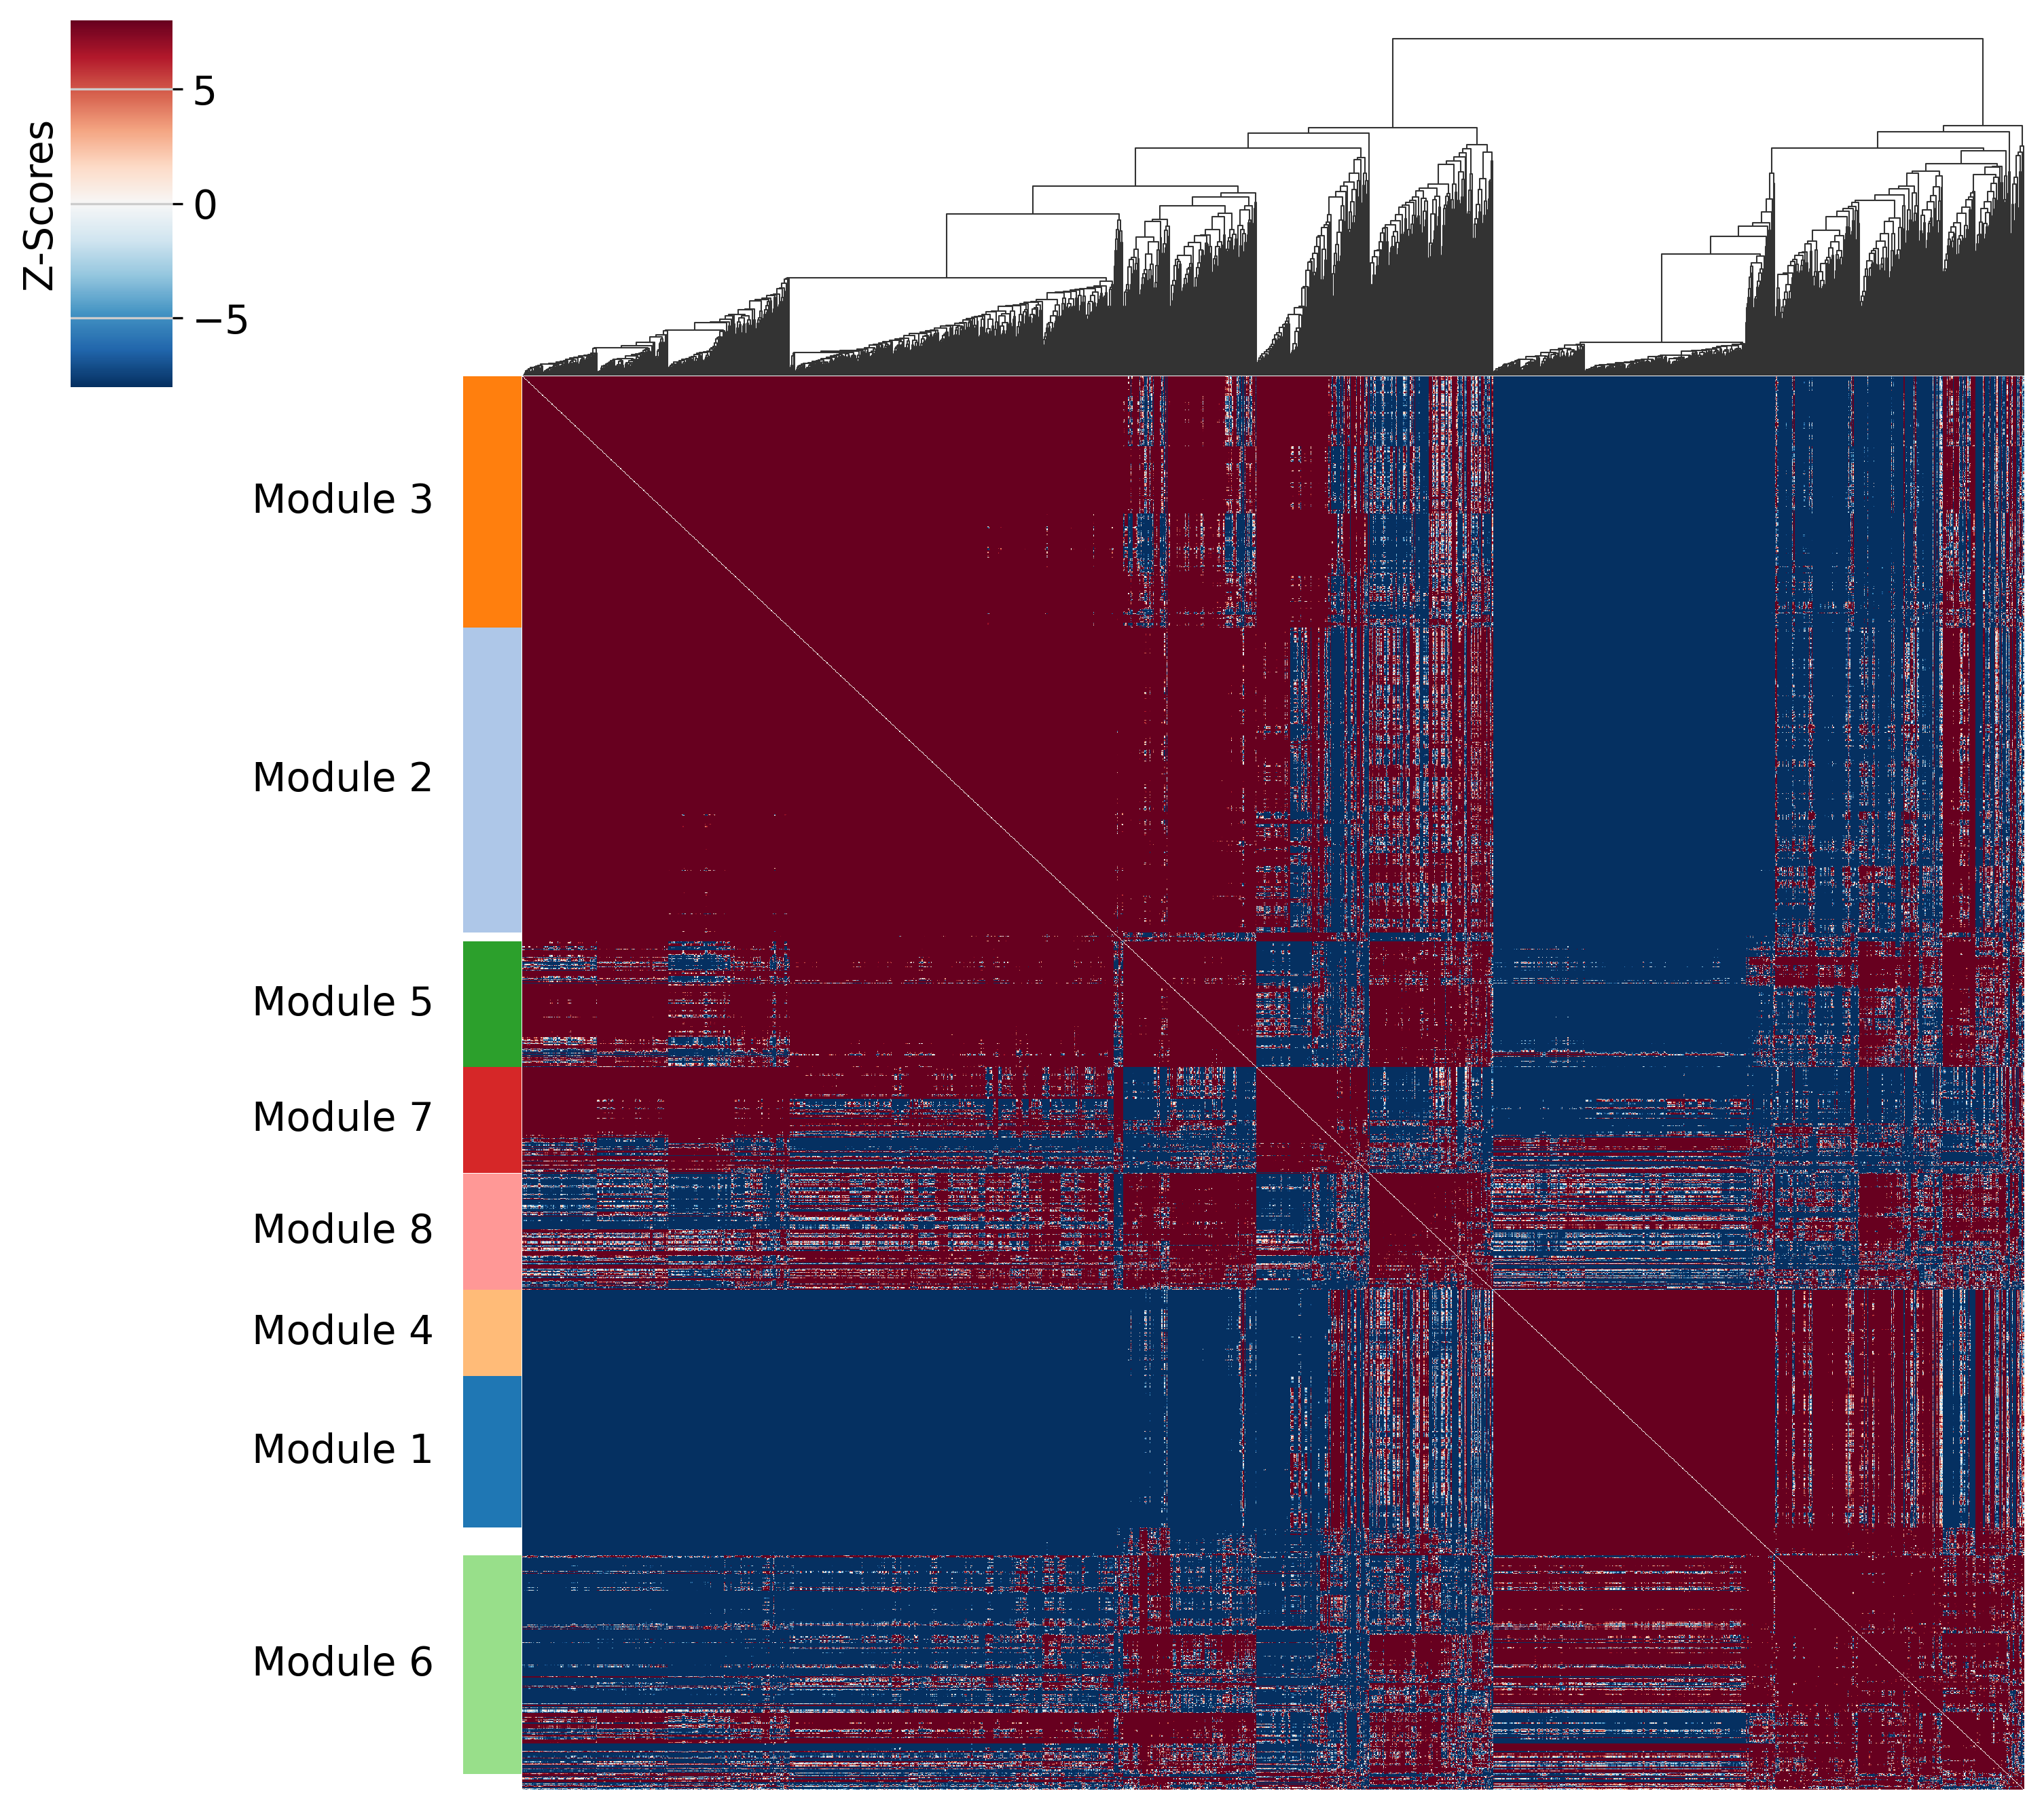

In [58]:
hs.plot_local_correlations(mod_cmap='tab20')


In [60]:
module_scores = hs.calculate_module_scores()

Computing scores for 8 modules...


100%|██████████| 8/8 [00:15<00:00,  1.89s/it]


In [65]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    ad.obs[key] = module_scores[c]
    module_cols.append(key)

In [63]:
module_scores.to_csv(f"{save_path}/module_scores.csv")